In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Data Ingestion

Definisco la cartella contenente i PDB

In [2]:
data_folder = 'refined'

Estrazione voxelizzazione e voxelizzazione anchor points

(55, 60, 61)
representation...


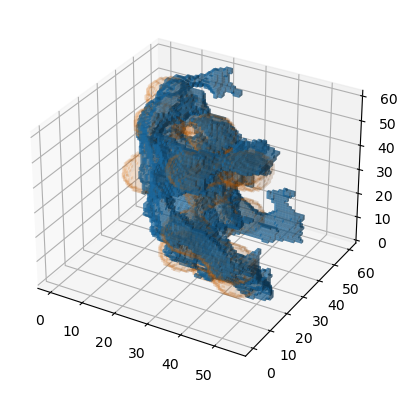

In [3]:
def extract_voxelization_and_anchor_points_voxelization(filename):
    X = list()                            # coordinate atomiche
    A = list()                            # anchor points
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee
    
    sparse = list()
    
    x_min,y_min,z_min,x_max,y_max,z_max = 0,0,0,0,0,0
    
    for line in Lines:
        if line.startswith("ANCHOR"):
            A.append(np.array(line.split()[1:]).astype(float))
        if line.startswith("GRIDG"):
            data = np.array(line.split()[2:]).astype(float)
            x_min,y_min,z_min,x_max,y_max,z_max = data[0],data[1],data[2],data[3],data[4],data[5]
        if line.startswith("GRIDVX"):
            coords = np.array(line.split()[1:4]).astype(int)
            if line.split()[-2] == 'P':
                sparse.append(coords)
    
    sparse = np.array(sparse).astype(int)
    grid = np.zeros( (
        np.max(sparse[:,0])+1,
        np.max(sparse[:,1])+1,
        np.max(sparse[:,2])+1
        )
    )
    
    anchor_grid = grid.copy()
    print(grid.shape)
    X   = jnp.linspace(x_min,x_max, grid.shape[0])
    Y   = jnp.linspace(y_min,y_max, grid.shape[1])
    Z   = jnp.linspace(z_min,z_max, grid.shape[2])
    
    XYZ = jnp.meshgrid(X,Y,Z, indexing = 'ij')
    
    for s in sparse:
        grid[s[0],s[1],s[2]] = 1.
    
    for a in A:
        a = jnp.array(np.array(a))
        sigma = 15.
        anchor_grid += jax.vmap(
                                lambda x,y,z: jnp.exp( - ((x - a[0])**2 + (y - a[1])**2 + (z - a[2])**2)/sigma )
                                )(
                                    XYZ[0],XYZ[1],XYZ[2]
                                )
        #a_x  = int( (a[0] - x_min)/(x_max - x_min) * (grid.shape[0] - 1))
        #a_y  = int( (a[1] - y_min)/(y_max - y_min) * (grid.shape[1] - 1))
        #a_z  = int( (a[2] - z_min)/(z_max - z_min) * (grid.shape[2] - 1))
        #for r_x in range(-3,3):
        #    for r_y in range (-3,3):
        #        for r_z in range (-3,3):
        #            if a_x + r_x > 0 and a_x + r_x < grid.shape[0]:
        #                if a_y + r_y > 0 and a_y + r_y < grid.shape[1]:
        #                    if a_z + r_z > 0 and a_z + r_z < grid.shape[2]:
        #                        anchor_grid[a_x + r_x,a_y + r_y,a_z + r_z] = 1.
    anchor_grid = np.array(anchor_grid)
    return grid,anchor_grid
vox,anchorvox = extract_voxelization_and_anchor_points_voxelization(r"refined\1ezq\1ezq_pocket.ligen.pdb")
print("representation...")
ax = plt.figure().add_subplot(projection = '3d')
ax.voxels(vox, alpha = 0.5)
ax.voxels(anchorvox > 0.5 , alpha = 0.1)
plt.show()

Definisco un metodo <code>extract_atom_coords_and_anchor_points</code> in grado di estrarre
1. la lista delle coordinate degli atomi
2. la lista delle coordinate degli anchor points

In [4]:
def extract_atom_coords_and_anchor_points(filename):
    X = list()                            # coordinate atomiche
    A = list()                            # anchor points
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee

    
    for line in Lines:
        if line.startswith("ANCHOR"):
            A.append(np.array(line.split()[1:]).astype(float))
        if line.startswith("ATOM"):
            X.append(np.array(line.split())[6:9].astype(float))
    
    X = np.array(X)
    print(X.min(axis = 0),X.max(axis = 0))

            
    return np.array(X),np.array(A)

# test
X,A = extract_atom_coords_and_anchor_points(r"refined\1ezq\1ezq_pocket.ligen.pdb")

[ -4.884 -12.279   3.189] [30.317 30.119 42.893]


Definisco un metodo <code>extract_ligand_information</code> che dato un file ligando, estrae i dati da esso

<IPython.core.display.Javascript object>


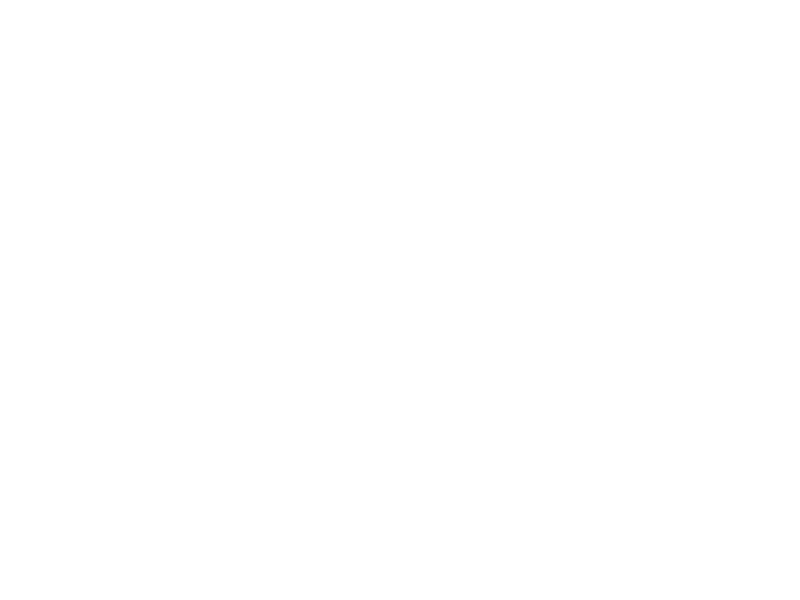

array(['N', 'C', 'N', 'C', 'C', 'C', 'O', 'N', 'N', 'C', 'C', 'C', 'O',
       'C', 'O', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'H'], dtype='<U1')

In [5]:
def extract_ligand_information(filename):
    X = list()                            # coordinate atomiche
    A = list()                            # atom list
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee

    reading_atoms = False
    for line in Lines:
        if line.startswith('@<TRIPOS>ATOM'):
            reading_atoms = True
        else:
            if reading_atoms:
                if line.startswith("@<TRIPOS>BOND"):
                    break
                else:
                    tokenized = line.split()
                    A.append(tokenized[5].split('.')[0])
                    X.append(tokenized[2:5])
    X = np.array(X).astype(float)
    A = np.array(A)
    return X,A

# test
%matplotlib notebook
test_ligand = "1a69"
L_X,L_A = extract_ligand_information("refined\\%s\\%s_ligand.mol2" % (test_ligand,test_ligand) )
ax = plt.figure().add_subplot(projection = '3d')
ax.scatter(L_X[:,0],L_X[:,1],L_X[:,2])
plt.show()
L_A

Definisco un metodo <code>process_ligand_information</code>, che embedda l'informazione sul ligando in un oggetto vettoriale

Ma prima, ci serve un container per le informazioni sugli atomi

In [6]:
import pandas as pd
periodic_table = pd.read_csv("periodic_table.csv").to_numpy()
atom_weight    = {}
for a in periodic_table:
    atom_weight[a[2]] = a[3]

Definiamo il numero di <b>clusters</b>

In [7]:
clusters       = 3
embedding_size = clusters * (6 + 3)  # ogni cluster ha : 6 elementi covmat, 3 elementi centro
embedding_size

27

Definizione del metodo

(27,)

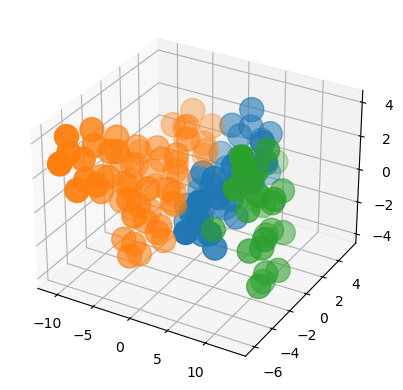

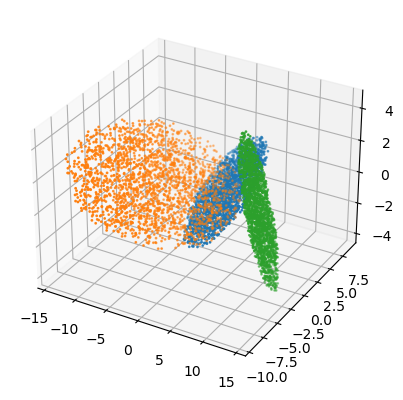

In [8]:
%matplotlib inline

from sklearn.cluster import KMeans
def process_ligand_information(X_,A, visualize = False):
    #     ellissi_1                       ellissi_2
    # ,---------------------------, ,------------------------,
    #  [pesotot][centro][covmat]            ...
    
    X = X_ - X_.mean(axis = 0)
    U,s,Vt = np.linalg.svd(X,full_matrices = False)
    X = X @ Vt.T
    
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    
    
    groups = [
            X[labels == l]
        for l in np.unique(labels)
    ]
    
    atoms_in_groups =  [
            A[labels == l]
        for l in np.unique(labels)
    ]
    
    
    def iso(symmat): 
        # isomorfismo matrice simmetrica 3x3 |--> vettore
        return np.array(
            [
                symmat[0,0],
                symmat[0,1],
                symmat[0,2],
                symmat[1,1],
                symmat[1,2],
                symmat[2,2]
            ]
        )
    
    def cov(data):
        data_zc = data - data.mean(axis = 0)
        return  1 / (len(data) - 1) * ( data_zc.T @ data_zc  )
    
    ret = np.array([])
    for g,a in zip(groups,atoms_in_groups):
        #weight = np.sum([ atom_weight[atom] for atom in a])
        #ret = np.r_[ret, weight]                    # peso tot
        ret = np.r_[ret, np.mean(g, axis = 0)]      # centro
        ret = np.r_[ret, iso(cov(g))]
    
    
    if visualize:
        def draw_ellipse(ax,center, cov_mat):
            X = np.random.uniform(size=(4000,3))
            X = (X - X.mean(axis = 0)) * 2.        # sfera di raggio 1
            X = X[np.linalg.norm(X,axis = 1) < 1.]
            X = (cov_mat @ X.T).T + center
            ax.scatter(X[:,0],X[:,1],X[:,2], s = 1.)
        
        ax = plt.figure().add_subplot(projection = '3d')
        for i,g in enumerate(groups):
            ax.scatter(g[:,0],g[:,1],g[:,2],s=300.)
            
        ax = plt.figure().add_subplot(projection = '3d')
        for i,g in enumerate(groups):
            center  = g.mean(axis = 0)
            covar   = cov(g)
            draw_ellipse(ax,center,covar)
    
    return ret
    
test_ligand = "1a94"
L_X,L_A = extract_ligand_information("refined\\%s\\%s_ligand.mol2" % (test_ligand,test_ligand) )
process_ligand_information(L_X,L_A,True).shape

Definisco un metodo <code>build_voxelizations</code> che prese in ingresso la lista delle coordinate atomiche e la lista delle coordinate degli anchor points restituisce le due voxelizzazioni

In [9]:
def build_voxelizations(X,A, size = 32):
    
    X_x_min,X_x_max = X[:,0].min(),X[:,0].max()
    X_y_min,X_y_max = X[:,1].min(),X[:,1].max()
    X_z_min,X_z_max = X[:,2].min(),X[:,2].max()
    A_x_min,A_x_max = A[:,0].min(),A[:,0].max()
    A_y_min,A_y_max = A[:,1].min(),A[:,1].max()
    A_z_min,A_z_max = A[:,2].min(),A[:,2].max()

    x_min, x_max = np.minimum(X_x_min,A_x_min), np.maximum(X_x_max,A_x_max)
    y_min, y_max = np.minimum(X_y_min,A_y_min), np.maximum(X_y_max,A_y_max)
    z_min, z_max = np.minimum(X_z_min,A_z_min), np.maximum(X_z_max,A_z_max)
    
    X_grid = np.zeros((size,size,size))
    A_grid = np.zeros((size,size,size))
    
    # popolo la voxel grid delle coordinate atomiche
    for x in X:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        X_grid[x_pos,y_pos,z_pos] = 1.
    
    # popolo la voxel grid degli anchor point
    for x in A:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        A_grid[x_pos,y_pos,z_pos] = 1.
        
    return X_grid, A_grid

# test
V_X, V_A = build_voxelizations(X,A)

Costruisco un metodo <code>voxelizations_from_file</code> che dato un file pdb in ingresso produce le voxelizzazioni, eventualmente con una callback di data augmentation

In [10]:
identity_augmentation = lambda U,V : (U,V)
def voxelizations_from_file(filename, size = 32, augmentation = identity_augmentation ):
    #X,A      = extract_atom_coords_and_anchor_points(filename)
    #X,A      = augmentation(X,A)
    #V_X, V_A = build_voxelizations(X,A, size)
    V_X,V_A = extract_voxelization_and_anchor_points_voxelization(filename)
    return V_X,V_A
V_X, V_A = voxelizations_from_file(r"refined\1ezq\1ezq_pocket.ligen.pdb")

(55, 60, 61)


# Data Visualization

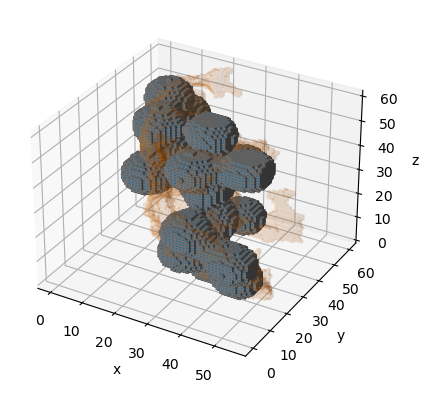

In [11]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A > 0.5, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

# Data augmentation

Il metodo <code>rotate</code> effettua una rotazione casuale sulla lista dei punti, nell'ottica che <b> una rotazione del sistema di riferimento non altera la posizione relativa gli anchor points </b>

In [12]:
def rotate(X,A):
    rotation = ( np.random.uniform() * 2 * np.pi , np.random.uniform() * 2 * np.pi, np.random.uniform() * 2 * np.pi )
    
    alfa  = rotation[0]
    beta  = rotation[1]
    gamma = rotation[2]
    
    R  = np.array([
        [ np.cos(beta) * np.cos(gamma) , 
          np.sin(alfa)*np.sin(beta)*np.cos(gamma) - np.cos(alfa)*np.sin(gamma), 
          np.cos(alfa)*np.sin(beta)*np.cos(gamma) + np.sin(alfa)*np.sin(gamma)
        ],
        [
          np.cos(beta)*np.sin(gamma) ,
          np.sin(alfa)*np.sin(beta)*np.sin(gamma) + np.cos(alfa) * np.cos(gamma),
          np.cos(alfa)*np.sin(beta)*np.sin(gamma) - np.sin(alfa) * np.cos(gamma)
        ],
        [
            - np.sin(beta),
            np.sin(alfa)*np.sin(beta),
            np.cos(alfa)*np.cos(beta)
        ]
    ])
    
    A_ = A - np.r_[A,X].mean(axis = 0)
    X_ = X - np.r_[A,X].mean(axis = 0)
    A_ = (R @ A_.T).T + np.r_[A,X].mean(axis = 0)
    X_ = (R @ X_.T).T + np.r_[A,X].mean(axis = 0)
    return X_,A_

(55, 60, 61)


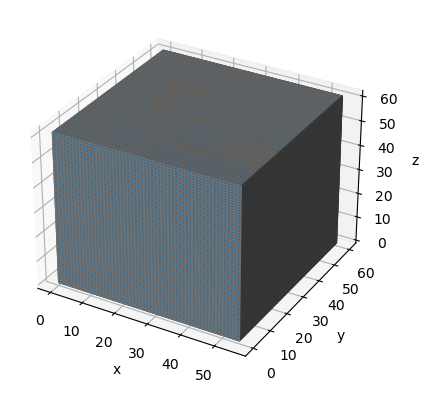

In [13]:
V_X, V_A = voxelizations_from_file(r"refined\1ezq\1ezq_pocket.ligen.pdb",
                                    size = 32,
                                    augmentation = rotate
                                  )
ax = make_ax(True)
ax.voxels(V_A, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

# Dataset Loading

In [14]:
train_ratio = 0.9

In [15]:
import os

augmentations       = 1

ligand_train        = []
ligand_test         = []
atomcoord_vox_train = []
anchorpts_vox_train = []
atomcoord_vox_test  = []
anchorpts_vox_test  = []

samples = 0
for root, dirnames, filenames in os.walk(data_folder):
        for dirname in dirnames:
            samples +=1
                
count = 0
for root, dirnames, filenames in os.walk(data_folder):
        for dirname in dirnames:
                pocket_name = dirname + "\\" + dirname+"_pocket.ligen.pdb"
                ligand_name = dirname + "\\" + dirname+"_ligand.mol2"
                
                for j in range(augmentations):
                    whole_pocket_path = '%s\\%s' % (root,pocket_name)
                    V_X,V_A = voxelizations_from_file( whole_pocket_path, 
                                                       size = 32, 
                                                       augmentation = rotate)
                    
                    whole_ligand_path = "%s\\%s" % (root,ligand_name)
                    L_X,L_A   = extract_ligand_information(whole_ligand_path)
                    embedding = process_ligand_information(L_X,L_A)
                    
                    if count <= train_ratio * samples:
                        atomcoord_vox_train.append(V_X)
                        anchorpts_vox_train.append(V_A)
                        ligand_train.append(embedding)
                    else:
                        atomcoord_vox_test.append(V_X)
                        anchorpts_vox_test.append(V_A)    
                        ligand_test.append(embedding)

                count += 1
                if int( count / (samples / 100)) != int( (count + 1)/(samples / 100) ):
                    print("%.2f %% loaded" % (count/samples * 100.) )

(50, 35, 67)
(50, 52, 58)
0.78 % loaded
(48, 54, 55)
(55, 57, 48)
(44, 64, 47)
1.95 % loaded
(65, 44, 67)
(40, 48, 53)
2.72 % loaded
(59, 66, 63)
(47, 44, 46)
(59, 58, 57)
3.89 % loaded
(49, 50, 43)
(52, 53, 71)
4.67 % loaded
(58, 36, 49)
(54, 53, 54)
(45, 49, 47)
5.84 % loaded
(35, 52, 62)
(36, 53, 61)
6.61 % loaded
(49, 46, 48)
(48, 47, 50)
(47, 44, 46)
7.78 % loaded
(53, 46, 70)
(45, 48, 52)
(50, 46, 50)
8.95 % loaded
(47, 46, 46)
(46, 46, 47)
9.73 % loaded
(57, 62, 56)
(58, 59, 54)
(45, 44, 49)
10.89 % loaded
(37, 45, 47)
(60, 50, 49)
11.67 % loaded
(66, 58, 54)
(46, 45, 60)
(53, 61, 51)
12.84 % loaded
(49, 44, 42)
(40, 55, 43)
13.62 % loaded
(48, 48, 39)
(61, 53, 55)
(63, 54, 64)
14.79 % loaded
(61, 61, 61)
(62, 57, 61)
(60, 57, 61)
15.95 % loaded
(53, 58, 57)
(61, 53, 62)
16.73 % loaded
(60, 56, 57)
(63, 57, 61)
(57, 54, 60)
17.90 % loaded
(63, 52, 62)
(61, 53, 55)
18.68 % loaded
(64, 54, 59)
(59, 53, 59)
(60, 54, 55)
19.84 % loaded
(62, 56, 57)
(48, 41, 49)
20.62 % loaded
(49, 4

In [16]:
atomcoord_vox_train = [ np.array(a) for a in atomcoord_vox_train ]
anchorpts_vox_train = [ np.array(a) for a in anchorpts_vox_train ]
atomcoord_vox_test  = [ np.array(a) for a in atomcoord_vox_test  ]
anchorpts_vox_test  = [ np.array(a) for a in anchorpts_vox_test  ]
ligand_train        = [ np.array(a) for a in ligand_train        ]
ligand_test         = [ np.array(a) for a in ligand_test         ]

In [17]:
print(
"N_train_data = %d\nN_train_labels = %d\nN_test_data = %d\nN_test_labels = %d\n"
%
(
len(atomcoord_vox_train) ,
len(anchorpts_vox_train) ,
len(atomcoord_vox_test ) ,
len(anchorpts_vox_test ) 
)
)

N_train_data = 232
N_train_labels = 232
N_test_data = 25
N_test_labels = 25



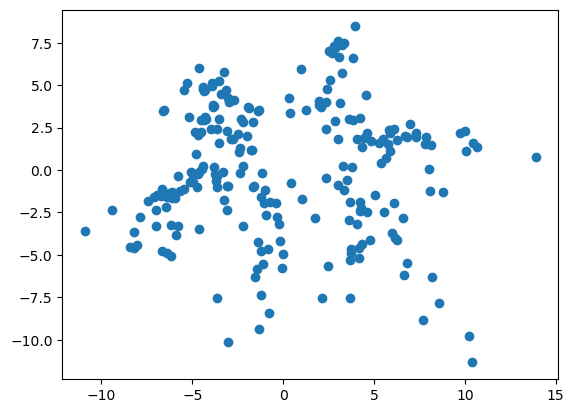

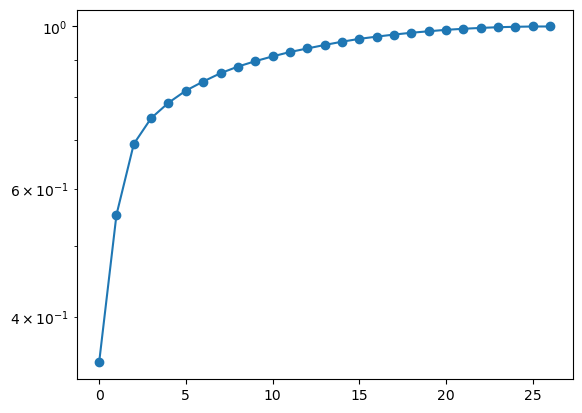

In [18]:
unique_LT  = np.unique(ligand_train, axis = 0)
unique_LT  = unique_LT - unique_LT.mean(axis = 0)
U,s,Vt = np.linalg.svd( unique_LT , full_matrices = False)
ligand_proj = unique_LT @ Vt.T[:,:2]
plt.scatter(ligand_proj[:,0],ligand_proj[:,1])
plt.figure()
plt.semilogy( np.cumsum(s**2)/np.sum(s**2), '-o')

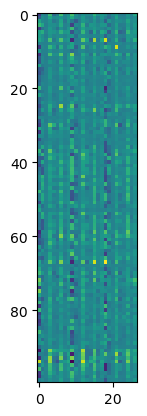

In [19]:
plt.imshow(ligand_train[:100])

# Network

In [20]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

In [21]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [22]:
def relu(x,w = 1.,b = 0.):
    return jnp.maximum(0,x * w + b)

def sigmoid(x,w = 1.,b = 0.):
    return (jnp.tanh(x * w + b) + 1.)/2.

def tanh(x,w=1.,b=0.):
    return jnp.tanh(x * w + b)

In [82]:
def linear(layer,W,b):
    return W @ layer + b

def chemical_contribution(W,b,W_2,b_2,embedding):
    x = linear(embedding,W,b)
    x = relu(x)
    x = linear(x,W_2,b_2)
    n = int( (len(b_2) + 1.)**(1./3.) )
    x = x.reshape(n,n,n)
    return x

def logistic_model(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,grid,embedding, alfa = 0.):
    x = conv3D(grid,W + alfa * chemical_contribution(W_5,b_5,W_6,b_6,embedding))
    x = relu(x)
    x = conv3D(x,W_2)
    x = relu(x)
    x = conv3D(x,W_3)    
    x = relu(x)
    x = conv3D(x,W_4)
    return x

In [83]:
def loss(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,
         grid,
         embedding,
         alfa,
         A):
    A_hat = logistic_model(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,
         grid,
         embedding,
         alfa,)
    return ((A - A_hat)**2).mean()
loss = jax.jit(loss)
grad = jax.grad(loss,argnums = (0,1,2,3,4,5,6,7))
grad = jax.jit(grad)

In [86]:
W = np.random.randn(5,5,5) * 1e-3
W_2 = np.random.randn(3,3,3) * 1e-3
W_3 = np.random.randn(3,3,3) * 1e-3
W_4 = np.random.randn(3,3,3) * 1e-3
W_5 = np.random.randn(10,embedding_size)
b_5 = np.random.randn(10)
W_6 = np.random.randn(5*5*5,10)
b_6 = np.random.randn(5*5*5)
grad(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,
     atomcoord_vox_train[150], 
     ligand_train[150],
     0.1,
     anchorpts_vox_train[150])

(DeviceArray([[[-1.01420407e-10, -4.21593593e-11,  1.29101341e-10,
                 3.04302451e-11,  2.07730763e-10],
               [-4.82788705e-11,  1.74528836e-10,  1.95028563e-10,
                -3.25479262e-11,  3.22884948e-12],
               [-1.46020362e-10, -1.20007893e-10, -8.07855866e-11,
                -8.19795828e-11, -1.40832962e-11],
               [-3.34963446e-10, -2.71190015e-10, -2.24772381e-10,
                -1.44992657e-10, -1.48253382e-10],
               [-1.10933554e-10, -1.42079792e-10, -2.84151348e-11,
                 5.01802211e-11, -2.52285498e-10]],
 
              [[-5.06568953e-11,  1.35375558e-10,  1.48556972e-10,
                 1.23990013e-10, -1.74385506e-11],
               [-7.33729223e-12,  1.11426070e-10,  1.89967382e-11,
                -7.41163034e-12, -6.78226780e-11],
               [-7.60825986e-11, -1.31698624e-10, -8.64245758e-11,
                 1.05421574e-12, -1.92760780e-10],
               [-1.86929652e-10, -1.19213164e-11,  3.

0
0.08891575
1
0.085831374
2
0.08830752
3
0.08963854
4
0.09062032
5
0.087615654
6
0.090414785
7
0.08807384
8
0.08803293
9
0.08868125
10
0.0861413
11
0.08675772
12
0.088686906
13
0.0871454
14
0.08644206
15
0.09043285
16
0.08607207
17
0.08959584
18
0.0867232
19
0.08700578
20
0.088468924
21
0.088980176
22
0.08906824
23
0.08616049
24
0.08830662
25
0.08708456
26
0.08890212
27
0.08812694
28
0.08749591
29
0.08663574
30
0.08968586
31
0.08601947
32
0.08850351
33
0.08992276
34
0.08561423
35
0.08825179
36
0.085672
37
0.08467224
38
0.0824214
39
0.06657345
40
0.05575139
41
0.045989715
42
0.041881837
43
0.03861762
44
0.03729853
45
0.036783073
46
0.035102576
47
0.035395935
48
0.033295047
49
0.034166228
50
0.032757502
51
0.032185033
52
0.031237917
53
0.03173867
54
0.031113563
55
0.03194887
56
0.030582966
57
0.031284723
58
0.030425644
59
0.03139486
60
0.030733103
61
0.03018327
62
0.02989706
63
0.029516049
64
0.030620968
65
0.030243812
66
0.02983009
67
0.02949686
68
0.029975437
69
0.028437333
70
0.02878

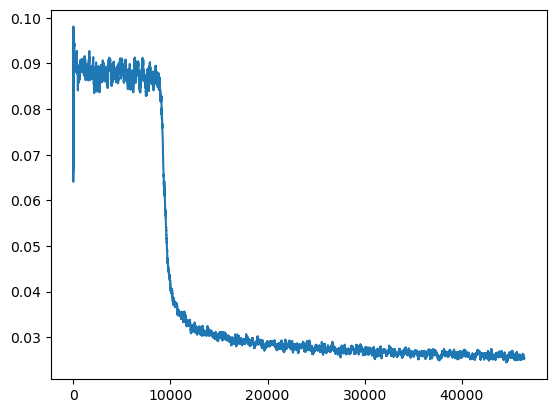

In [89]:
np.random.seed(123)
W = jnp.array(np.random.randn(5,5,5))   * jnp.sqrt(2./ (5*5*5))
W_2 = jnp.array(np.random.randn(3,3,3)) * jnp.sqrt(2./ (3*3*3))
W_3 = jnp.array(np.random.randn(3,3,3)) * jnp.sqrt(2./ (3*3*3))
W_4 = jnp.array(np.random.randn(3,3,3)) * jnp.sqrt(2./ (3*3*3))

W_5 = np.random.randn(10,embedding_size) * 1e-4
b_5 = np.random.randn(10)                * 1e-4
W_6 = np.random.randn(5*5*5,10)          * 1e-4
b_6 = np.random.randn(5*5*5)             * 1e-4

errors = []
losses = []
alpha  = 0.
for e in range(200):
    print(e)
    for i in range(len(anchorpts_vox_train)):
        n      = np.random.choice(len(anchorpts_vox_train))
        sample = atomcoord_vox_train[n]
        ligand = ligand_train[n]
        label  = anchorpts_vox_train[n]
        
        if e > 100:
            alpha = 1.0
        else:
            alpha = 0.
            
        g      = grad(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,sample,ligand, alpha, label)
        W   = W - 0.01 * g[0]
        W_2 = W_2 - 0.01 * g[1]
        W_3 = W_3 - 0.01 * g[2]
        W_4 = W_4 - 0.01 * g[3]
        W_5 = W_5 - 0.01 * g[4]
        b_5 = b_5 - 0.01 * g[5]
        W_6 = W_6 - 0.01 * g[6]
        b_6 = b_6 - 0.01 * g[7]
        errors.append(loss(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,sample,ligand, alpha, label))
        losses.append(np.mean(errors[-100:]))
    print(np.mean(errors[-100:]))
plt.figure()
plt.plot(losses)

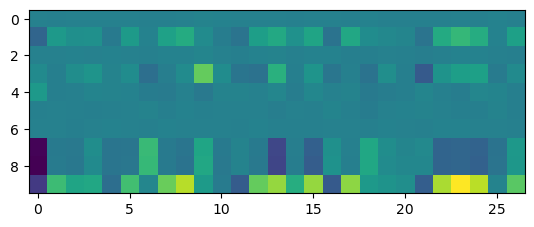

In [96]:
plt.imshow(W_5)

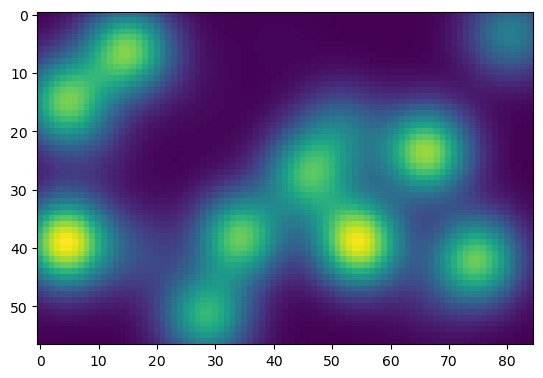

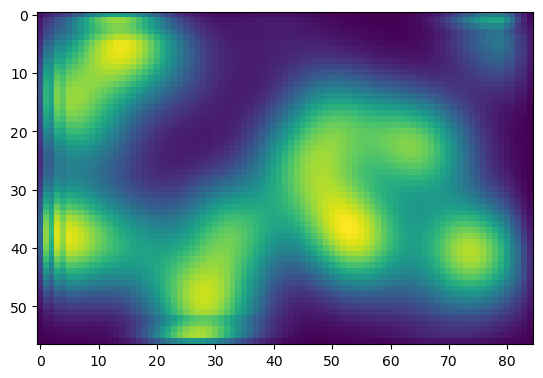

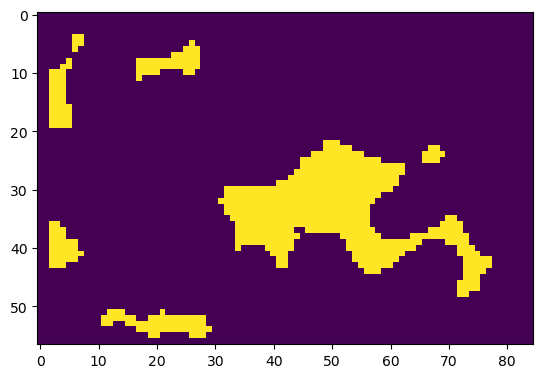

In [109]:
fetta = 39
sample = 20
plt.imshow( anchorpts_vox_test[sample][fetta,:,:])
plt.figure()
plt.imshow(logistic_model(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,
                          anchorpts_vox_test[sample],
                          ligand_test[sample], 
                          1.0)[fetta,:,:] )
plt.figure()
plt.imshow( atomcoord_vox_test[sample][fetta,:,:])

# Visualizzazione

In [103]:
sample = 17
V_A_hat = np.array( logistic_model(W,W_2,W_3,W_4,W_5,b_5,W_6,b_6,
                          anchorpts_vox_test[sample],
                          ligand_test[sample], 
                          1.0))
V_A     = anchorpts_vox_test[sample]
V_X     = atomcoord_vox_test[sample]

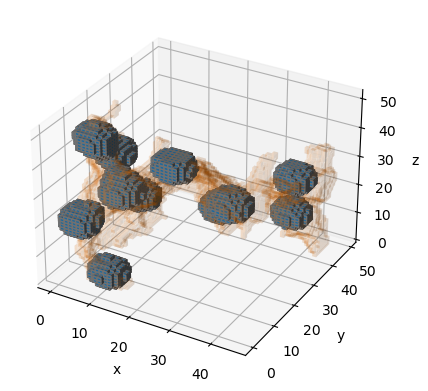

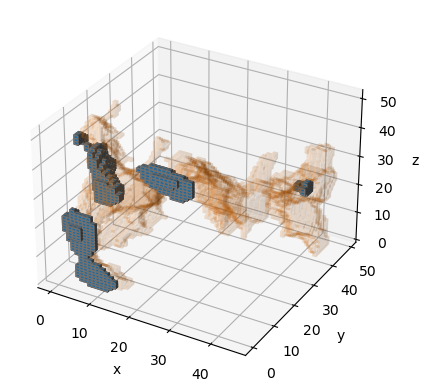

In [107]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A > 0.7, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

ax = make_ax(True)
ax.voxels(V_A_hat > 0.3, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

In [106]:
V_A_hat.max()

0.46258557